In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image

In [9]:
# import os
# import cv2
# data_path="./Final-dataset"
# data_dir_list = ['class-alzheimers', 'class-frontotemporal', 'class-healthy']
# # img_data_list=[]
# labels = []
# for dataset in data_dir_list:
#     img_list=os.listdir(data_path+'/'+ dataset)
#     print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
#     for img in img_list:
#         if img[-3:] == 'jpg':
#             input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
# #             input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
#             labels.append(dataset)
#             input_img_resize=cv2.resize(input_img,(128, 128))
#             img_data_list.append(input_img_resize)
# label=np.array(labels)
# img_data = np.array(img_data_list)
# img_data = img_data.astype('float32')
# img_data = img_data/255
# img_data.shape

#                        *********** Main code for final data laoding and training Starts here *********

import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder

data_path = "./Final-dataset"
data_dir_list = ['class-alzheimers', 'class-frontotemporal', 'class-healthy']
img_data_list = []
labels = []

for dataset in data_dir_list:
    img_list = os.listdir(os.path.join(data_path, dataset))
    print('Loaded the images of dataset-{}\n'.format(dataset))
    for img in img_list:
        if img[-3:] == 'png':
            input_img = cv2.imread(os.path.join(data_path, dataset, img))
            # Convert the image to grayscale if needed
            # input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
            labels.append(dataset)
            input_img_resize = cv2.resize(input_img, (256, 256))  # update the pixel size (if needed)
            img_data_list.append(input_img_resize)

label_encoder = LabelEncoder()
label_encoder.fit(labels)
label = label_encoder.transform(labels)

img_data = np.array(img_data_list).astype('float32') / 255

# Calculate sample count for each class
class_counts = np.bincount(label)

# Display the sample count for each class
for i, count in enumerate(class_counts):
    print(f"Class {i}: {count} samples")


Loaded the images of dataset-class-alzheimers

Loaded the images of dataset-class-frontotemporal

Loaded the images of dataset-class-healthy

Class 0: 883 samples
Class 1: 533 samples
Class 2: 786 samples


In [30]:
# from keras.utils import to_categorical
# from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split

# num_classes = 3
# Y = to_categorical(label, num_classes)
# x, y = shuffle(img_data, Y, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# print("X_train shape:", X_train.shape)
# print("X_test shape:", X_test.shape)
# print("y_train shape:", y_train.shape)
# print("y_test shape:", y_test.shape)




from keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

num_classes = 3

# Ensure labels are in a format that matches the number of samples in img_data
assert img_data.shape[0] == len(label), "Mismatch in the number of samples between img_data and label"

Y = to_categorical(label, num_classes)

# Shuffle the dataset
x, y = shuffle(img_data, Y, random_state=42)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Print shapes to verify
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Ensure that the number of samples match between the train/test sets for both x and y
assert X_train.shape[0] == y_train.shape[0], "Mismatch in train set sizes"
assert X_test.shape[0] == y_test.shape[0], "Mismatch in test set sizes"



X_train shape: (1761, 256, 256, 3)
X_test shape: (441, 256, 256, 3)
y_train shape: (1761, 3)
y_test shape: (441, 3)


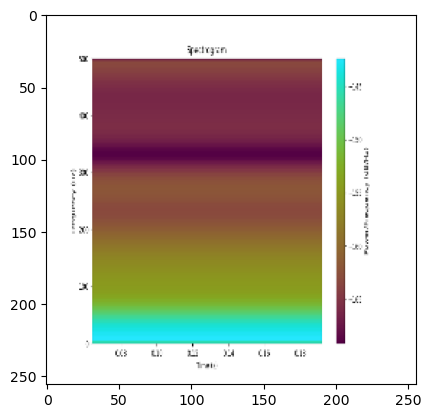

In [31]:
plt.imshow(img_data_list[1])

In [32]:
X_train = X_train.reshape(-1, 128, 128, 3)
X_test = X_test.reshape(-1, 128, 128, 3)
X_train.shape
# X_test.shape

print("Input features shape:", X_train.shape)
print("Target labels shape:", y_train.shape)


Input features shape: (7044, 128, 128, 3)
Target labels shape: (1761, 3)


In [33]:
from tensorflow.keras.layers import Conv2D, Dropout, Activation, Multiply, Input, Add, Flatten, GlobalMaxPooling2D, Dense, Reshape, BatchNormalization, GlobalAveragePooling2D, Permute
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import tensorflow as tf

def cbam_attention(inputs, reduction_ratio=8):
    # Channel attention
    x = inputs
    channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
    channel = x.shape[channel_axis]
    
    shared_layer_one = Dense(channel // reduction_ratio, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.003), activation='relu')
    shared_layer_two = Dense(channel, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.003), use_bias=True)

    avg_pool = GlobalAveragePooling2D()(x)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(x)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

        
    attention_feature = Multiply()([x, cbam_feature])

    # Spatial attention
    kernel_size = 7
    spatial_attention = Conv2D(1, (kernel_size, kernel_size), kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.003), padding='same')(attention_feature)

    if tf.keras.backend.image_data_format() == "channels_first":
        spatial_attention = Permute((3, 1, 2))(spatial_attention)

    attention_feature = Multiply()([attention_feature, spatial_attention])

    return attention_feature

def residual_block(input_layer, filters, kernel_size):
    x = layers.Conv2D(filters, kernel_size, padding='same')(input_layer)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.ReLU()(x)
    # Add a 1x1 convolutional layer to adjust the number of channels
    adjust_channels = layers.Conv2D(filters, (1, 1), padding='same')(input_layer)
    x = Add()([x, adjust_channels])
    return x

# Explicitly name the input layer
visible = Input(shape=(128, 128, 3))

ds_1 = Conv2D(filters=32, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.003), activation='relu')(visible)
x1 = BatchNormalization()(ds_1)
ds_2 = Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.003), activation='relu')(x1)
x2 = BatchNormalization()(ds_2)
ds_3 = Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.003), activation='relu')(x2)
x3 = BatchNormalization()(ds_3)
ds_4 = Conv2D(filters=256, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.003), activation='relu')(x3)
x4 = BatchNormalization()(ds_4)
# ds_5 = Conv2D(filters=512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.003), activation='relu')(ds_4)
c = cbam_attention(x4, 8)

# Residual block 1
x = residual_block(c, filters=32, kernel_size=(3, 3))


#replace global average pulling 
# Spatial Pyramid Pooling (SPP)
# pool_sizes = [4, 2, 1] 
# spp_layers = []
# for pool_size in pool_sizes:
#     spp = layers.MaxPooling2D(pool_size=(pool_size, pool_size))(x)
#     spp = layers.Flatten()(spp)
#     spp_layers.append(spp)

# spp = layers.Concatenate()(spp_layers)
# x = layers.Dense(512, activation='relu')(spp)
# x1 = layers.Dropout(0.25)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x1 = Dropout(0.25)(x)

# Fully Connected Layers
x10 = Dense(256, activation='relu')(x1)
x10 = Dense(128, activation='relu')(x10)

# Output Layer
output_layer = Dense(2, activation='softmax')(x10)

# Create the final model
model = Model(inputs=visible, outputs=output_layer)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 128, 128,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │    295,168 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │      1,024 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ batch_normalizat… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1, 1, 256) │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 1, 1, 256) │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1, 1, 32)  │      8,224 │ reshape_4[0][0],  │
│                     │                   │            │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1, 1, 256) │      8,448 │ dense_12[0][0],   │
│                     │                   │            │ dense_12[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 1, 1, 256) │          0 │ dense_13[0][0],   │
│                     │                   │            │ dense_13[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 1, 1, 256) │          0 │ add_4[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 692,163 (2.64 MB)

 Trainable params: 691,203 (2.64 MB)

 Non-trainable params: 960 (3.75 KB)

In [34]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer = Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['acc'])
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    patience=30,
    min_delta=0.001,
    monitor="val_acc",
    restore_best_weights=True
)

# Define the ModelCheckpoint callback to save the best weights
checkpoint_directory =  './checkpoint1'
epoch= 200
checkpoint = ModelCheckpoint(
   checkpoint_directory + f'Epoch1_{epoch}.keras', 
    monitor='val_acc',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [35]:
history = model.fit(
     X_train,
     y_train,
     epochs=200,
     batch_size=16,
     validation_data=(X_test, y_test),
     callbacks=[checkpoint],
     verbose=1
    )

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 7044
'y' sizes: 1761


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Multiply, Input, Add, Flatten, GlobalMaxPooling2D, Dense, Reshape, GlobalAveragePooling2D, Permute, Concatenate
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import tensorflow as tf

def cbam_attention(inputs, reduction_ratio=8):
    # Channel attention
    x = inputs
    channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
    channel = x.shape[channel_axis]
    
    shared_layer_one = Dense(channel // reduction_ratio, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), activation='relu')
    shared_layer_two = Dense(channel, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), use_bias=True)

    avg_pool = GlobalAveragePooling2D()(x)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(x)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    attention_feature = Multiply()([x, cbam_feature])

    # Spatial attention
    kernel_size = 7
    spatial_attention = Conv2D(1, (kernel_size, kernel_size), kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), padding='same')(attention_feature)

    if tf.keras.backend.image_data_format() == "channels_first":
        spatial_attention = Permute((3, 1, 2))(spatial_attention)

    attention_feature = Multiply()([attention_feature, spatial_attention])

    return attention_feature

def residual_block(input_layer, filters, kernel_size):
    x = layers.Conv2D(filters, kernel_size, padding='same')(input_layer)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.ReLU()(x)
    # Add a 1x1 convolutional layer to adjust the number of channels
    adjust_channels = layers.Conv2D(filters, (1, 1), padding='same')(input_layer)
    x = Add()([x, adjust_channels])
    return x

# Explicitly name the input layer
visible = Input(shape=(128, 128, 3), name='input_image')
x1 = Conv2D(128, (3, 3), dilation_rate=1, padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), activation='relu')(visible)
x1 = BatchNormalization()(x1)
x2 = Conv2D(128, (3, 3), dilation_rate=3, padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), activation='relu')(x1)
x2 = BatchNormalization()(x2)
x3 = Conv2D(128, (3, 3), dilation_rate=5, padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), activation='relu')(x2)
x3 = BatchNormalization()(x3)

A1 = Add()([x1, x2])
M1 = Multiply()([x2, x3])

x4 = Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), activation='relu')(A1)
x4 = BatchNormalization()(x4)
g1 = GlobalAveragePooling2D()(x4)
d1 = Dense(1, activation='sigmoid')(g1)
M3 = Multiply()([d1, x1])

x5 = Activation('softmax')(M1)
M2 = Multiply()([x3, x5])

# Concatenate layers
C1 = Concatenate()([M2, M3])
x5 = Conv2D(256, (3, 3), padding = 'same', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), activation='relu')(C1)
C2 = Concatenate()([x5, visible])
x = cbam_attention(C2)
x = Add()([x, C2])
# Residual block 1
r = residual_block(x, filters=64, kernel_size=(3, 3))

x = layers.Dense(128, activation='relu')(r)
x1 = layers.Dropout(0.25)(x)

x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
# x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x)
model = Model(inputs=visible, outputs=output)
model.summary()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    patience=15,
    min_delta=0.001,
    monitor="val_acc",
    restore_best_weights=True
)

# Define the ModelCheckpoint callback to save the best weights
checkpoint_directory =  '/workspace/All/Osteoporosis knee/Code/Checkpoints'
epoch= 200
checkpoint = ModelCheckpoint(
   checkpoint_directory + f'Epoch1_{epoch}.h5', 
    monitor='val_acc',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [ ]:
history = model.fit(
     X_train,
     y_train,
     epochs=200,
     batch_size=16,
     validation_data=(X_test, y_test),
     callbacks=[checkpoint, early_stopping],
     verbose=1
    )